In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light38_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [4]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Mon Mar  8 13:25:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 67%   58C    P2   197W / 370W |   6631MiB / 24268MiB |     41%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 55%   

In [5]:
save_dir = 'save/light38_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [6]:
!ls $save_dir

ls: cannot access 'save/light38_model': No such file or directory


In [7]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 0

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if False:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 162.3MiB
TTS size 156.0MiB
MelEncoder size 52.3MiB
MelDecoder size 94.9MiB
0
done


In [8]:
trainset = LJDataset(tts_hparams.root_dir)
collate_fn = TextMelCollate()
train_loader = torch.utils.data.DataLoader(trainset, num_workers=tts_hparams.num_workers, 
                          shuffle=True,
                          sampler=None,
                          batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)

print(train_loader)

In [9]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.01602051258087158


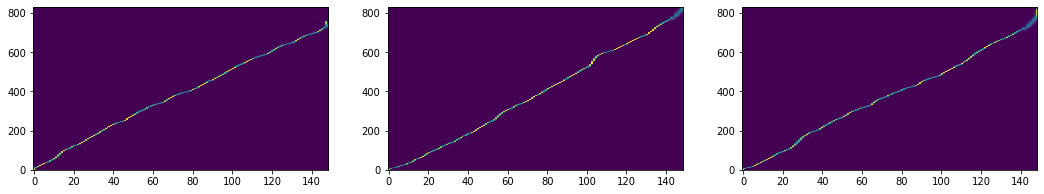

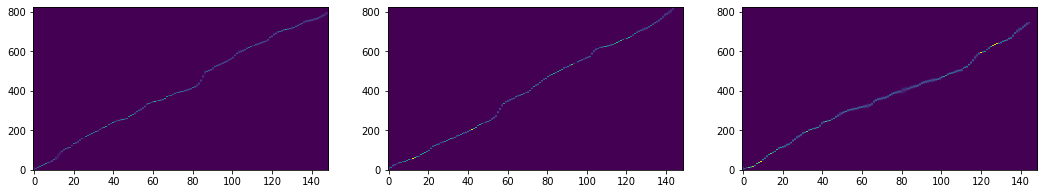

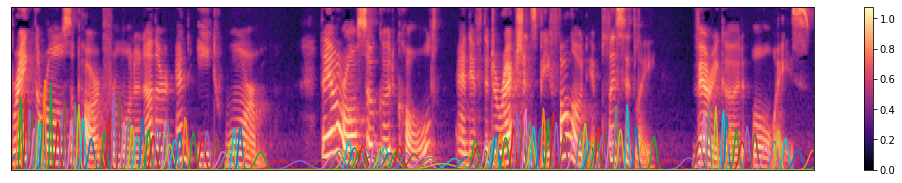

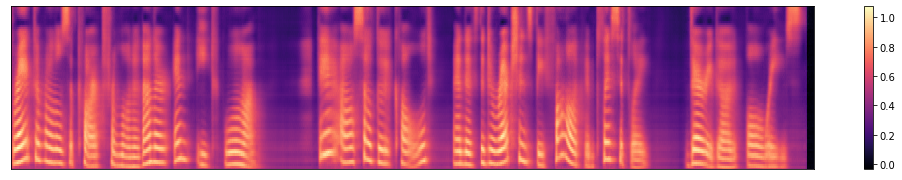

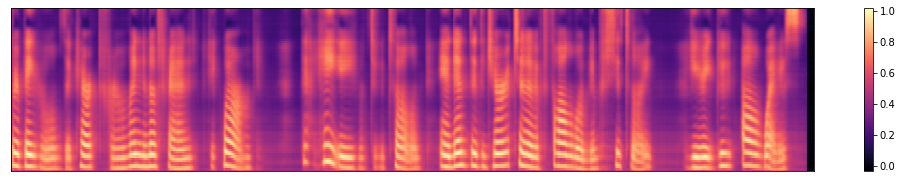

tensor(5.1474, device='cuda:0')
step : 7001 stt : 0.7337 tts : 0.1286 recon : 0.0028 kl : 0.0081 beta : 0.1401
tensor(1.1576, device='cuda:0')
step : 7002 stt : 0.8223 tts : 0.1315 recon : 0.0028 kl : 0.0083 beta : 0.1402
tensor(3.3923, device='cuda:0')
step : 7003 stt : 0.7565 tts : 0.1321 recon : 0.0025 kl : 0.0083 beta : 0.1402
tensor(0.9337, device='cuda:0')
step : 7004 stt : 0.7028 tts : 0.1279 recon : 0.0027 kl : 0.0084 beta : 0.1402
tensor(2.4261, device='cuda:0')
step : 7005 stt : 0.7068 tts : 0.1286 recon : 0.0023 kl : 0.0080 beta : 0.1402
tensor(1.0447, device='cuda:0')
step : 7006 stt : 0.7955 tts : 0.1341 recon : 0.0025 kl : 0.0081 beta : 0.1402
tensor(1.6229, device='cuda:0')
step : 7007 stt : 0.7383 tts : 0.1238 recon : 0.0026 kl : 0.0078 beta : 0.1403
tensor(1.7580, device='cuda:0')
step : 7008 stt : 0.7308 tts : 0.1314 recon : 0.0024 kl : 0.0075 beta : 0.1403
tensor(2.5703, device='cuda:0')
step : 7009 stt : 0.7740 tts : 0.1298 recon : 0.0028 kl : 0.0081 beta : 0.1403
t

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta.item())
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta.item())    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=0.7)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(_y[index])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(_s[index, :, :_y.shape[2]])
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [26]:
logger.save(step, model, optimizer)

saved save/light38_model/save_2931


torch.Size([1, 80, 856]) 0.011872766017913818
{'alignment': 0.00041103363037109375, 'random': 0.0001456737518310547, 'last_conv': 0.00575566291809082, 'z_proj': 0.00014138221740722656, 'cond': 0.0007834434509277344, 'up': 0.0009636878967285156, 'encode': 0.0039403438568115234, 'pad': 3.1948089599609375e-05, 'enc_conv': 0.0009388923645019531, 'enc_lstm': 0.0028352737426757812}


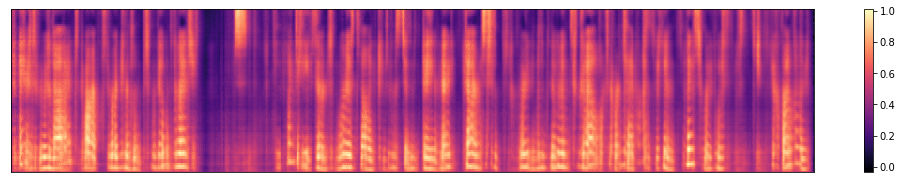

In [27]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for batch in train_loader:
    batch = to_cuda(batch)
    break
        
model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(100):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [28]:
time_sum = 0
for key in time_dict.keys():
    time_sum += time_dict[key]

for key in time_dict.keys():
    print(key, '%0.2f' % (time_dict[key] / time_sum))


alignment 0.03
random 0.01
last_conv 0.36
z_proj 0.01
cond 0.05
up 0.06
encode 0.25
pad 0.00
enc_conv 0.06
enc_lstm 0.18
